In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/cdc_project/train_images/train /content/train_images

In [ ]:
!cp -r /content/drive/MyDrive/cdc_project/test_images/test /content/test_images

In [ ]:
BASE_PATH = "/content/drive/MyDrive/cdc_project"
TRAIN_CSV_PREPROCESSED = f"{BASE_PATH}/train_preprocessed.csv"
TRAIN_IMG_PATH = "/content/train_images"

TEST_CSV_PREPROCESSED = f"{BASE_PATH}/test_preprocessed.csv"
TEST_IMG_PATH = "/content/test_images"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 5
LR = 1e-3
RANDOM_STATE = 42

In [ ]:
df_train = pd.read_csv(TRAIN_CSV_PREPROCESSED)
df_test = pd.read_csv(TEST_CSV_PREPROCESSED)

df_train["id"] = df_train["id"].astype(str)
df_test["id"]  = df_test["id"].astype(str)

In [ ]:
FEATURE_COLS = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'above_ground_ratio', 'bath_per_bed',
       'living_to_lot_ratio', 'relative_living_size', 'relative_lot_size',
       'neighborhood_density', 'distance_from_center', 'waterfront_view',
       'house_age', 'is_renovated', 'years_since_reno', 'year_sale',
       'month_sale', 'quarter_sale']

X_train = df_train[FEATURE_COLS].values
X_test  = df_test[FEATURE_COLS].values

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled  = scaler_x.transform(X_test)

y_log = df_train["log_price"].values
y_mean = y_log.mean()
y_std  = y_log.std()

y_scaled = (y_log - y_mean) / y_std

In [ ]:
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, tabular_data, indices, image_dir, targets=None, transform=None):
        self.tabular = tabular_data
        self.targets = targets            # None for test set
        self.indices = indices.astype(str)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        row_id = self.indices[idx]
        img_path = os.path.join(self.image_dir, f"{row_id}.png")

        # --- Image (CV2 stays exactly same) ---
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        # --- Tabular ---
        tabular_features = torch.tensor(
            self.tabular[idx], dtype=torch.float32
        )

        # --- TRAIN MODE ---
        if self.targets is not None:
            target = torch.tensor(self.targets[idx], dtype=torch.float32)
            return image, tabular_features, target

        # --- TEST MODE ---
        else:
            return image, tabular_features, row_id

In [ ]:
train_ds = MultimodalDataset(
    tabular_data=X_train_scaled,
    targets=y_scaled,
    indices=df_train["id"].values,
    image_dir=TRAIN_IMG_PATH,
    transform=image_transform
)

test_ds = MultimodalDataset(
    tabular_data=X_test_scaled,
    targets=None,
    indices=df_test["id"].values,
    image_dir=TEST_IMG_PATH,
    transform=image_transform
)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(weights="DEFAULT")
        self.features = nn.Sequential(*list(base.children())[:-1])
        self.output_dim = 512

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)

class MLPEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.output_dim = 32

    def forward(self, x):
        return self.net(x)

class MultimodalRegressor(nn.Module):
    def __init__(self, tabular_dim):
        super().__init__()
        self.cnn = CNNEncoder()
        self.mlp = MLPEncoder(tabular_dim)

        self.regressor = nn.Sequential(
            nn.Linear(self.cnn.output_dim + self.mlp.output_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.mlp(tabular)
        fused = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(fused).squeeze(1)

model = MultimodalRegressor(tabular_dim=X_train_scaled.shape[1]).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
epoch_loss = 0

for epoch in range(EPOCHS):
    model.train()
    train_losses = []

    for imgs, tabs, targets in train_loader:
        imgs = imgs.to(DEVICE)
        tabs = tabs.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        preds = model(imgs, tabs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1} | Avg Loss: {epoch_loss:.4f}")

Epoch 1 | Avg Loss: 0.2488
Epoch 2 | Avg Loss: 0.1331
Epoch 3 | Avg Loss: 0.1165
Epoch 4 | Avg Loss: 0.1079
Epoch 5 | Avg Loss: 0.1019


In [ ]:
model.eval()
preds, ids_all = [], []

with torch.no_grad():
    for img, x_tab, ids in test_loader:
        img = img.to(DEVICE)
        x_tab = x_tab.to(DEVICE)

        pred = model(img, x_tab)

        preds.append(pred.cpu().numpy())
        ids_all.extend(ids)

preds = np.concatenate(preds)


In [ ]:
preds_log = preds * y_std + y_mean
preds_price = np.expm1(preds_log)


In [ ]:
submission = pd.DataFrame({
    "id": ids_all,
    "predicted_price": preds_price
})


In [ ]:
submission.describe()

,predicted_price
count,5.404000e+03
mean,5.855867e+05
std,3.769002e+05
min,1.403582e+05
25%,3.638808e+05
50%,5.082618e+05
75%,6.919793e+05
max,6.659089e+06


In [ ]:
len(submission)

5404

In [ ]:
submission.to_csv("/content/drive/MyDrive/cdc_project/final_predictions.csv", index=False)

In [ ]:
# saving the model in drive to access them later (if needed)
import joblib
from joblib import dump

SAVE_DIR = "/content/drive/MyDrive/cdc_project/models"
os.makedirs(SAVE_DIR, exist_ok=True)

torch.save(model.state_dict(), f"{SAVE_DIR}/multimodal_model.pth")
joblib.dump(scaler_x, f"{SAVE_DIR}/tabular_scaler.pkl")

np.savez(
    f"{SAVE_DIR}/target_norm.npz",
    y_mean=y_mean,
    y_std=y_std
)


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self):
        # Global-average-pool gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam


In [ ]:
def run_gradcam(example_id, image_dir, df_tabular):
    model.eval()

    # --- Load image ---
    img_path = os.path.join(image_dir, f"{example_id}.jpg")
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_resized = cv2.resize(image, (224, 224))
    img_tensor = image_transform(image_resized).unsqueeze(0).to(DEVICE)

    # --- Load tabular features ---
    tab = df_tabular.loc[df_tabular["id"] == example_id, FEATURE_COLS].values
    tab = torch.tensor(tab, dtype=torch.float32).to(DEVICE)

    # --- GradCAM ---
    cam_extractor = GradCAM(model, model.cnn.features[-2])

    output = model(img_tensor, tab)
    model.zero_grad()
    output.backward()

    cam = cam_extractor.generate()[0].detach().cpu().numpy()

    # --- Visualization ---
    heatmap = cv2.resize(cam, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(image_resized, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM | House ID: {example_id}")
    plt.show()


In [ ]:
sample_ids = []

# Cheapest house
sample_ids.append(
    df_train.sort_values("log_price").iloc[0]["id"]
)

# Median-priced house
sample_ids.append(
    df_train.sort_values("log_price").iloc[len(df_train)//2]["id"]
)

# Most expensive house
sample_ids.append(
    df_train.sort_values("log_price").iloc[-1]["id"]
)
waterfront_house = (
    df_train[df_train["waterfront"] == 1]
    .sort_values("log_price", ascending=False)
    .iloc[0]["id"]
)

sample_ids.append(waterfront_house)

non_waterfront_house = (
    df_train[df_train["waterfront"] == 0]
    .sort_values("log_price", ascending=False)
    .iloc[0]["id"]
)

sample_ids.append(non_waterfront_house)


In [ ]:
high_density_house = (
    df_train.sort_values("neighborhood_density", ascending=False)
    .iloc[0]["id"]
)

sample_ids.append(high_density_house)

low_density_house = (
    df_train.sort_values("neighborhood_density")
    .iloc[0]["id"]
)

sample_ids.append(low_density_house)


In [ ]:
sample_ids

['3421079032',
 '4028900048',
 '6762700020',
 '9808700762',
 '6762700020',
 '2722059275',
 '2062600020']

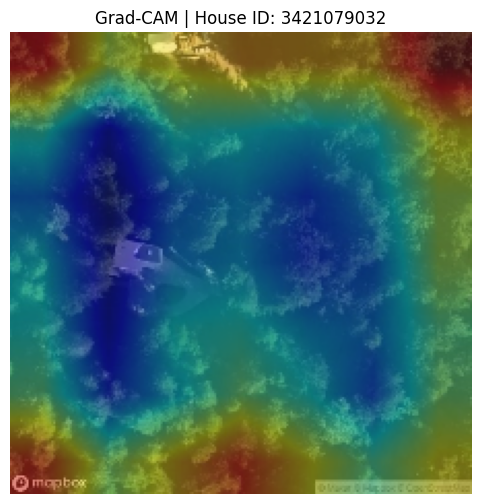

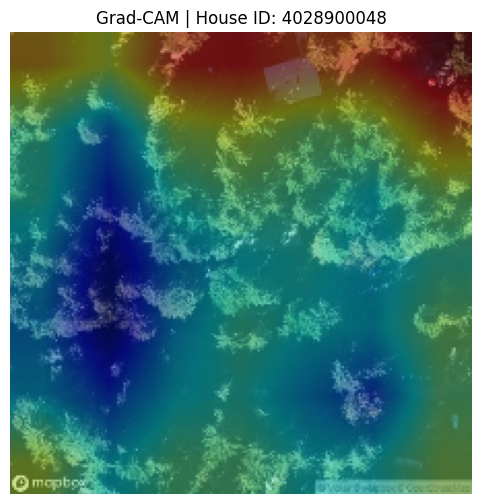

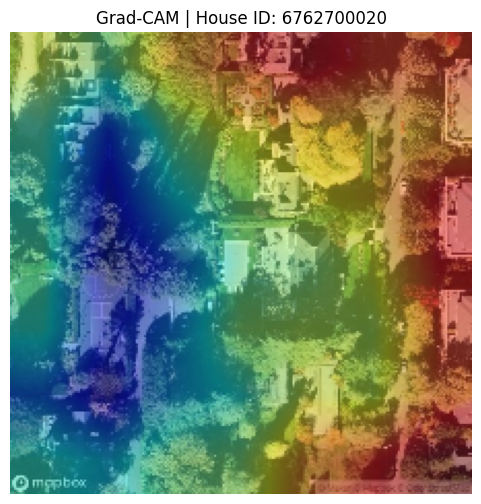

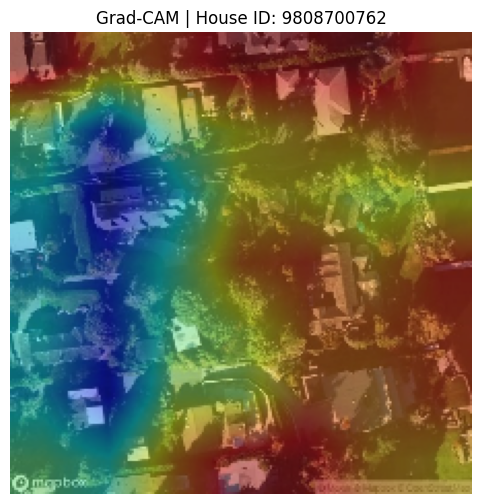

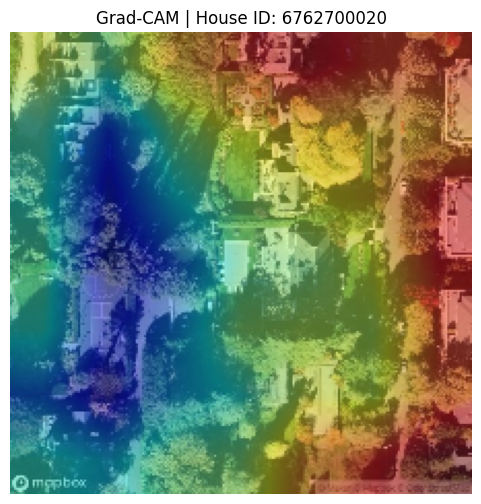

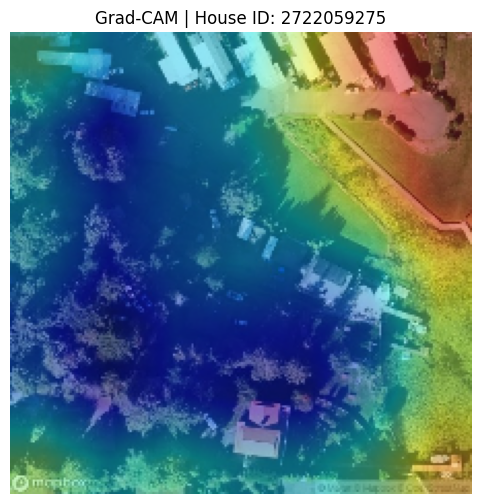

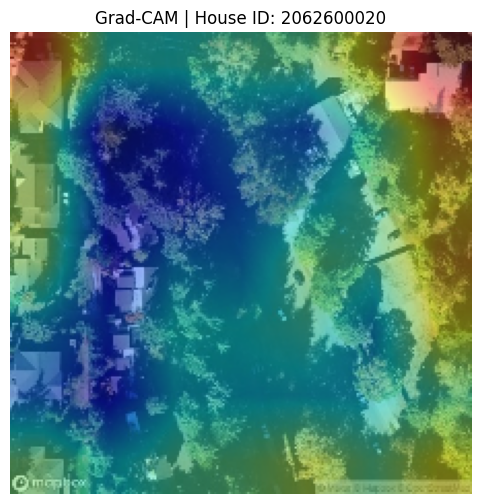

In [ ]:
for example_id in sample_ids:
    run_gradcam(example_id, "/content/grad_cam_images", df_train)